# Accumulation investment simulation
Excahnge rate is NOT included!!

In [1]:
nisa_capacity = 18000000
monthly_investment_until_fill_nisa = 100000
monthly_investment_after_fill_nisa = 0
accumulation_year = 35

monthly_withdrawal_after_retirement = 100000
year_after_retirement = 30

# ticker_symbol = "ACWI"  # All Country World Index
ticker_symbol = "^GSPC"  # S&P 500
# ticker_symbol = "^N225"  # Nikkei 225

monte_carlo_simulation_time = 100000

## Index history and score

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

index_data = yf.download(ticker_symbol, period="max")
index_data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2025-01-03,5942.470215,5949.339844,5888.660156,5891.069824,3667340000
2025-01-06,5975.379883,6021.040039,5960.009766,5982.810059,4940120000


In [3]:
# Resample to monthly data and get Open and Close
monthly_index = index_data.resample('ME').agg({('Open', ticker_symbol): 'first', ('Close', ticker_symbol): 'last'})
# Calculate the monthly return
monthly_index['Return'] = monthly_index['Close'].pct_change()
# Drop the first and last row, which is the current month
monthly_index = monthly_index.iloc[1:-1]
# monthly_index.to_csv('monthly_index.csv')
monthly_index

Price,Open,Close,Return
Ticker,^GSPC,^GSPC,
Date,,,
1928-01-31,17.760000,17.570000,-0.005096
1928-02-29,17.530001,17.260000,-0.017644
1928-03-31,17.299999,19.280001,0.117034
1928-04-30,18.910000,19.750000,0.024378
1928-05-31,19.780001,20.000000,0.012658
...,...,...,...
2024-08-31,5537.839844,5648.399902,0.022835
2024-09-30,5623.890137,5762.479980,0.020197


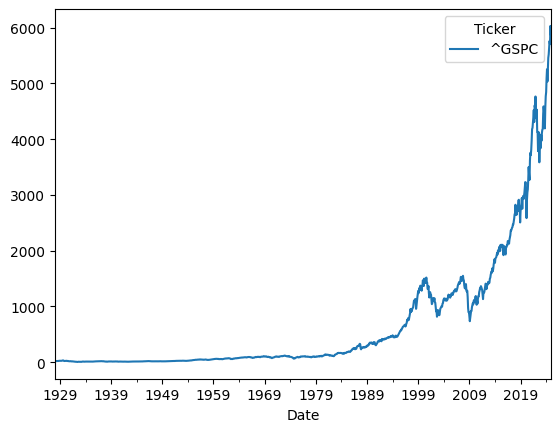

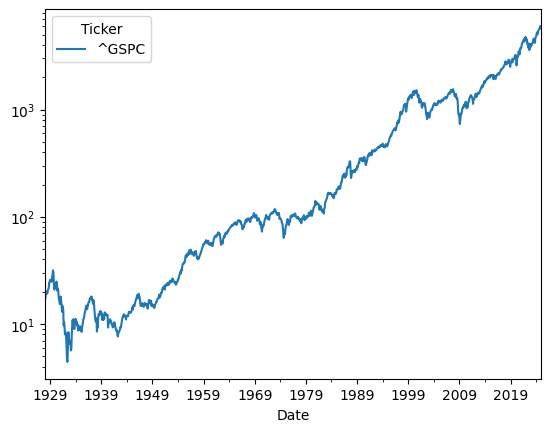

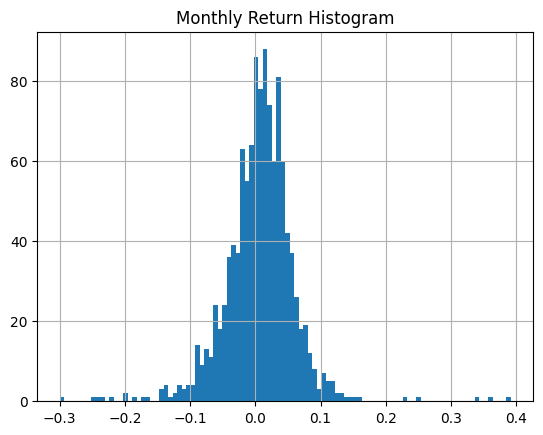

mean:  0.006439051297105919
std:  0.05352993204502133


In [4]:
# Visualize the monthly index chart
monthly_index['Close'].plot()
plt.show()
monthly_index['Close'].plot(logy=True)
plt.show()
# Visualize the monthly return histogram
monthly_index['Return'].hist(bins=100)
plt.title('Monthly Return Histogram')
plt.show()
# Calculate the mean and standard deviation of the monthly return
mean_monthly_return = monthly_index['Return'].mean()
std_monthly_return = monthly_index['Return'].std()
print("mean: ", mean_monthly_return)
print("std: ", std_monthly_return)

## Monte Carlo simulation until retirement

In [5]:
result = []
for n in range(monte_carlo_simulation_time):
    accumulated_principal = 0
    market_value = 0
    for year in range(accumulation_year):
        for month in range(12):
            if accumulated_principal < nisa_capacity:
                accumulated_principal += monthly_investment_until_fill_nisa
                market_value += monthly_investment_until_fill_nisa
            else:
                accumulated_principal += monthly_investment_after_fill_nisa
                market_value += monthly_investment_after_fill_nisa

            market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))
            
    result.append(market_value)
result = pd.Series(result)
# print(result.mean())
# print(result.std())
print("Principal: ", accumulated_principal)
print("========================================")
print("Worst case: ", int(result.min()))
print("Bottom 1%: ", int(result.quantile(0.01)))
print("Bottom 2%: ", int(result.quantile(0.02)))
print("Bottom 3%: ", int(result.quantile(0.03)))
print("Bottom 4%: ", int(result.quantile(0.04)))
print("Bottom 5%: ", int(result.quantile(0.05)))
print("Bottom 10%: ", int(result.quantile(0.1)))
print("Bottom 20%: ", int(result.quantile(0.2)))
print("Bottom 30%: ", int(result.quantile(0.3)))
print("Median: ", int(result.quantile(0.5)))
print("Top 10%: ", int(result.quantile(0.9)))

Principal:  18000000
Worst case:  1926209
Bottom 1%:  11192982
Bottom 2%:  14592181
Bottom 3%:  17291019
Bottom 4%:  19437160
Bottom 5%:  21525546
Bottom 10%:  30128337
Bottom 20%:  45558368
Bottom 30%:  61568686
Median:  100867414
Top 10%:  340566301


## Monte Carlo simulation lifetime

In [6]:
result = []
for n in range(monte_carlo_simulation_time):
    accumulated_principal = 0
    market_value = 0
    for year in range(accumulation_year):
        for month in range(12):
            if accumulated_principal < nisa_capacity:
                accumulated_principal += monthly_investment_until_fill_nisa
                market_value += monthly_investment_until_fill_nisa
            else:
                accumulated_principal += monthly_investment_after_fill_nisa
                market_value += monthly_investment_after_fill_nisa

            market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))

    total_withdrawal = 0        
    for year in range(year_after_retirement):
        for month in range(12):
            total_withdrawal -= monthly_withdrawal_after_retirement
            market_value -= monthly_withdrawal_after_retirement
            if market_value > 0:
                market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))
            else:
                # Bankrupt
                market_value = market_value

    result.append(market_value)
result = pd.Series(result)
# print(result.mean())
# print(result.std())
print("Principal: ", accumulated_principal)
print("total_withdrawal: ", total_withdrawal)
print("========================================")
print("Worst case: ", int(result.min()))
print("Bottom 1%: ", int(result.quantile(0.01)))
print("Bottom 2%: ", int(result.quantile(0.02)))
print("Bottom 3%: ", int(result.quantile(0.03)))
print("Bottom 4%: ", int(result.quantile(0.04)))
print("Bottom 5%: ", int(result.quantile(0.05)))
print("Bottom 10%: ", int(result.quantile(0.1)))
print("Bottom 20%: ", int(result.quantile(0.2)))
print("Bottom 30%: ", int(result.quantile(0.3)))
print("Median: ", int(result.quantile(0.5)))
print("Top 10%: ", int(result.quantile(0.9)))

Principal:  18000000
total_withdrawal:  -36000000
Worst case:  -34210177
Bottom 1%:  -23027954
Bottom 2%:  -17653993
Bottom 3%:  -12829902
Bottom 4%:  -7556945
Bottom 5%:  -1645787
Bottom 10%:  31599053
Bottom 20%:  105602385
Bottom 30%:  197911630
Median:  485077610
Top 10%:  3384809118


## Monte Carlo simulation only after retirement

In [7]:
initial_capital = 50000000



result = []
for n in range(monte_carlo_simulation_time):
    accumulated_principal = initial_capital
    market_value = initial_capital

    total_withdrawal = 0        
    for year in range(year_after_retirement):
        for month in range(12):
            total_withdrawal -= monthly_withdrawal_after_retirement
            market_value -= monthly_withdrawal_after_retirement
            if market_value > 0:
                market_value *= (1 + np.random.normal(mean_monthly_return, std_monthly_return))
            else:
                # Bankrupt
                market_value = market_value

    result.append(market_value)
result = pd.Series(result)
# print(result.mean())
# print(result.std())
print("Principal: ", accumulated_principal)
print("total_withdrawal: ", total_withdrawal)
print("========================================")
print("Worst case: ", int(result.min()))
print("Bottom 1%: ", int(result.quantile(0.01)))
print("Bottom 2%: ", int(result.quantile(0.02)))
print("Bottom 3%: ", int(result.quantile(0.03)))
print("Bottom 4%: ", int(result.quantile(0.04)))
print("Bottom 5%: ", int(result.quantile(0.05)))
print("Bottom 10%: ", int(result.quantile(0.1)))
print("Bottom 20%: ", int(result.quantile(0.2)))
print("Bottom 30%: ", int(result.quantile(0.3)))
print("Median: ", int(result.quantile(0.5)))
print("Top 10%: ", int(result.quantile(0.9)))

Principal:  50000000
total_withdrawal:  -36000000
Worst case:  -23446592
Bottom 1%:  -7272556
Bottom 2%:  -1482549
Bottom 3%:  3259574
Bottom 4%:  7572864
Bottom 5%:  11639366
Bottom 10%:  28817294
Bottom 20%:  61733869
Bottom 30%:  97390650
Median:  192274505
Top 10%:  841969773
